# Prepare data

In [2]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [4]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)
train_df.head()

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Flower, Fish}",1,1,0,0
1,002be4f.jpg,"{Flower, Sugar, Fish}",1,1,1,0
2,0031ae9.jpg,"{Flower, Sugar, Fish}",1,1,1,0
3,0035239.jpg,"{Flower, Gravel}",0,1,0,1
4,003994e.jpg,"{Sugar, Gravel, Fish}",1,0,1,1


In [5]:
# train_df['img_id'] = train_df.Image_Label.apply(lambda x: x.split('_')[0])
# train_df['label'] = train_df.Image_Label.apply(lambda x: x.split('_')[-1])

# labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
# classes = {}

# for label in labels:
#     df = train_df[train_df.label == label].dropna()
#     classes[label] = df.img_id.values
    
# from tqdm import tqdm
# img_names = train_df.img_id.unique()
# label_strings = {}

# for img in tqdm(img_names):
#     label_string = ''
#     for label in labels:
#         if img in classes[label]:
#             label_string += f'{label} '
#     label_strings[img] = label_string[:-1]
    
# X = pd.DataFrame(list(label_strings.items()), columns=['img', 'label'])
# X.to_csv('../input/train_classes_fastai.csv', index=False)    

# from tqdm import tqdm
# X = {}
# for img in tqdm(train_df.img_id.unique()):
#     y = np.zeros(4)
#     x = {}
#     for i, label in enumerate(labels):
#         if img in classes[label]:
#             x[label] = 1.
#         else:
#             x[label] = 0.
#         X[img] = x            
        
# X = pd.DataFrame(X).T       
# X.to_csv('../input/train_classes.csv')

In [6]:
img_2_ohe_vector = {img:vec for img, vec in zip(train_df['Image'], train_df.iloc[:, 2:].values)}

In [6]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs = train_test_split(train_df['Image'].values, 
                                        test_size=0.2, 
                                        stratify=train_df['Class'].map(lambda x: str(sorted(list(x)))), 
                                        random_state=10)

In [7]:
# from keras.utils import Sequence
# from copy import deepcopy

# class DataGenenerator(Sequence):
#     def __init__(self, images_list=None, folder_imgs="../input/train", 
#                  batch_size=32, shuffle=True, augmentation=None,
#                  resized_height=224, resized_width=224, num_channels=3):
        
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.augmentation = augmentation
        
#         if images_list is None:
#             self.images_list = os.listdir(folder_imgs)
#         else:
#             self.images_list = deepcopy(images_list)
#         self.folder_imgs = folder_imgs
#         self.len = len(self.images_list) // self.batch_size
#         self.resized_height = resized_height
#         self.resized_width = resized_width
#         self.num_channels = num_channels
#         self.num_classes = 4
#         self.is_test = not 'train' in folder_imgs
#         if not shuffle and not self.is_test:
#             self.labels = [img_2_ohe_vector[img] for img in self.images_list[:self.len*self.batch_size]]

#     def __len__(self):
#         return self.len
    
#     def on_epoch_start(self):
#         if self.shuffle:
#             random.shuffle(self.images_list)

#     def __getitem__(self, idx):
#         current_batch = self.images_list[idx * self.batch_size: (idx + 1) * self.batch_size]
#         X = np.empty((self.batch_size, self.resized_height, self.resized_width, self.num_channels))
#         y = np.empty((self.batch_size, self.num_classes))

#         for i, image_name in enumerate(current_batch):
#             path = os.path.join(self.folder_imgs, image_name)
#             img = cv2.resize(cv2.imread(path), (self.resized_height, self.resized_width)).astype(np.float32)
#             if not self.augmentation is None:
#                 augmented = self.augmentation(image=img)
#                 img = augmented['image']
#             X[i, :, :, :] = img/255.0
#             if not self.is_test:
#                 y[i, :] = img_2_ohe_vector[image_name]
#         return X, y

#     def get_labels(self):
#         if self.shuffle:
#             images_current = self.images_list[:self.len*self.batch_size]
#             labels = [img_2_ohe_vector[img] for img in images_current]
#         else:
#             labels = self.labels
#         return np.array(labels)

In [8]:
# f = "../input/train_images_525/train_images_525"
# data_generator_train = DataGenenerator(train_imgs, folder_imgs=f, augmentation=get_training_augmentation())

In [9]:
# for x in data_generator_train:
#     print(len(x))
#     print(x[1].shape)
#     print(x[0].shape)
#     print(x[1])
#     break

# Classifier in PyTorch

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import albumentations as albu
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader,Dataset
import cv2

plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_img(fname, folder="../input/train_images_525/train_images_525"):
    img = cv2.imread(os.path.join(folder, fname))
#     return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def get_training_augmentation():
    train_transform = [
        albu.CLAHE(p=1),
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
#         albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.1, p=0.3, border_mode=0),
#         albu.HueSaturationValue(p=0.5),
        albu.GridDistortion(),
#         albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
#         albu.Normalize()
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    train_transform = [
        albu.CLAHE(p=1),
#         albu.Normalize()
    ]
    return albu.Compose(train_transform)

class CloudDataset(Dataset):
    def __init__(
        self,
        datatype = "train",
        img_ids = None,
        df = None,
        transforms = None, 
        preprocessing = None,
    ):
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.datatype = datatype
        self.df = df
    
    
    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        cols = ['Fish', 'Flower', 'Gravel', 'Sugar']
#         label = self.df[self.df.img==image_name][cols].values        
        
        if self.datatype == 'test':
            #something
            return img, label   
                        
        img = get_img(image_name)
        augmented = self.transforms(image=img)
        img = augmented["image"]
        
        if self.preprocessing:
            pp = self.preprocessing(image=img)
            img = pp['image']
#         label.to(dtype=torch.float32)

        label = img_2_ohe_vector[image_name]        
        label = torch.tensor(label, dtype=torch.float32, device=device).squeeze()
        img = torch.Tensor(img.transpose(2, 0, 1)).type(torch.float32)
        return img/255.0, label

    def __len__(self):
        return len(self.img_ids)

In [1]:
df = pd.read_csv('../input/train_classes.csv')
df = df.rename(columns={'Unnamed: 0':'img'})
ids = df.img.values

train_ids, valid_ids = train_test_split(ids, test_size=0.2)
print(len(train_ids))
print(len(valid_ids))

NameError: name 'pd' is not defined

In [13]:
num_workers = 0
# bs = 16
bs = 8
train_dataset = CloudDataset(datatype='train', 
                             img_ids=train_ids, df = df,
                             transforms = get_training_augmentation())
train_loader = DataLoader(train_dataset, batch_size=bs, 
                          shuffle=True, num_workers=num_workers)

val_dataset = CloudDataset(datatype='val', 
                             img_ids=valid_ids, df = df,
                             transforms = get_validation_augmentation())
val_loader = DataLoader(val_dataset, batch_size=bs, 
                          shuffle=True, num_workers=num_workers)

torch.Size([3, 350, 525])
torch.float32
tensor([1., 0., 1., 1.], device='cuda:0')
torch.float32


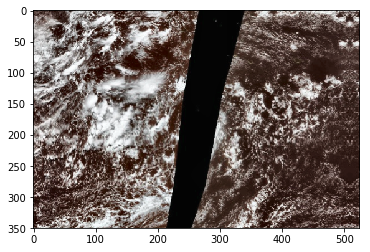

In [14]:
# Test dataloader
for x in train_loader:
    img = x[0][1]
    label = x[1][1]
    print(img.shape)
    print(img.dtype)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    print(label)
    print(label.dtype)
    break

# Define model

In [15]:
# import torch.nn.functional as F

# def get_model(num_classes, pretrained=True, freeze=True):
#     model = models.inception_v3(pretrained=pretrained)
#     if freeze:
#         for param in model.parameters():
#             param.requires_grad = False
#     else:
#         for param in model.parameters():
#             param.requires_grad = True
            
#     in_ftrs = model.fc.in_features
#     model.fc = nn.Linear(in_ftrs, num_classes)
    
#     in_ftrs = model.AuxLogits.fc.in_features
#     model.AuxLogits.fc = nn.Linear(in_ftrs, num_classes)
    
#     return model

from efficientnet_pytorch import EfficientNet
def get_model(num_classes, pretrained=True, freeze=True):
    model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=num_classes) 

    if freeze:
        for i, param in list(model.named_parameters())[:-10]:
            param.requires_grad = False
    
    else:
        for param in model.parameters():
            param.requires_grad = True
            
    return model

In [16]:
# class CloudModel(nn.Module):
#     def __init__(self, n_classes=4, pretrained=True, freeze=True):
#         super(CloudModel, self).__init__()
#         self.inception=get_model(n_classes, pretrained, freeze)
#         self.sig = nn.Sigmoid()
        
#     def forward(self, x):
#         x = self.inception(x)
#         if self.training:
#             return x[0], x[1]
# #             return self.sig(x[0]), self.sig(x[1])
#         else:
#             return x
# #             return self.sig(x)
    
#     def unfreeze(self):
#         for param in model.parameters():
#             param.requires_grad = True
            
class CloudModel(nn.Module):
    def __init__(self, n_classes=4, pretrained=True, freeze=True):
        super(CloudModel, self).__init__()
        self.model=get_model(n_classes)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        return self.sig(x)
    
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True            

In [17]:
nc = 4
model = CloudModel(nc).to(device)
# model = get_model(nc).to(device)
# model.unfreeze()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

Loaded pretrained weights for efficientnet-b2


In [18]:
from sklearn.metrics import precision_recall_curve, auc

def compute_pr_auc(y_true, y_pred, n_classes=4):
        y_true = y_true.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
        pr_auc_mean = 0
        for class_i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true[:, class_i], y_pred[:, class_i])
            if np.isnan(np.sum(precision)) or np.isnan(np.sum(recall)):
                continue
            pr_auc = auc(recall, precision)
            pr_auc_mean += pr_auc/n_classes
        return pr_auc_mean

In [19]:
def train(model, criterion, optimizer, scheduler, num_epochs = 25, unfreeze=False):
    if unfreeze:
        for param in model.parameters():
            param.requires_grad = True
    dataloaders = {'train':train_loader, 'val':val_loader}

    since = time.time()
    val_score_history = []
    val_auc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = -100000

    for epoch in tqdm(range(num_epochs)):
            print(f"Epoch {epoch}/{num_epochs-1}")
            print('-' * 10)

            for phase in ['train', 'val']:
#             for phase in ['val', 'train']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_pr_auc = 0.0


                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        pr_auc = compute_pr_auc(labels, outputs) 
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_pr_auc += pr_auc * inputs.size(0)
#                     scheduler.step(running_loss)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_pr_auc = running_pr_auc / len(dataloaders[phase].dataset)

                print('{} Loss: {:.4f}'.format(phase, epoch_loss))
                print(f"{phase}: AUC: {epoch_pr_auc}")
                
                if phase == 'val':
                    if epoch_loss < best_epoch_loss:
                        best_epoch_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                    val_score_history.append(epoch_loss)
                    val_auc_history.append(epoch_pr_auc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)
    return model, val_score_history, val_auc_history

In [20]:
def train(model, criterion, optimizer, scheduler, num_epochs = 25, unfreeze=False):

    val_auc_hist = -10000
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)
        
        running_loss = 0.
        running_pr_auc = 0.    
        for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(labels)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    pr_auc = compute_pr_auc(labels, outputs)
                    running_loss += loss.item()/len(train_loader)
                    running_pr_auc += pr_auc/len(train_loader)
        print(f"TRAIN>>> Loss: {running_loss} | AUC: {running_pr_auc}")         
        
#         with torch.no_grad():
#             running_loss = 0.
#             running_pr_auc = 0.
#             for inputs, labels in tqdm(val_loader):
#                     inputs = inputs.to(device)
#                     labels = labels.to(labels)
#                     outputs = model(inputs)
#                     running_loss += criterion(outputs, labels).item()/len(val_loader)
#                     running_pr_auc += compute_pr_auc(labels, outputs)/len(val_loader)
#             if running_pr_auc > val_auc_hist:
#                 val_auc_hist = running_pr_auc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#                 best_epoch = epoch
#             print(f"VAL>>> Loss: {running_loss} | AUC: {running_pr_auc}")         

#     model.load_state_dict(best_model_wts)
#     print(f"best_epoch was: {best_epoch}")
    return model

In [21]:
import math
num_epochs = 20
if True:
    val_auc_hist = -10000
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)
        
        running_loss = 0.
        running_pr_auc = 0.    
        for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(labels)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    pr_auc = compute_pr_auc(labels, outputs)
                    running_loss += loss.item()/len(train_loader)
                    running_pr_auc += pr_auc/len(train_loader)
        print(f"TRAIN>>> Loss: {running_loss} | AUC: {running_pr_auc}")       

Epoch 0/19
----------


/home/timetraveller/.local/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]



TRAIN>>> Loss: 0.6269218963008742 | AUC: 0.7758330626544913
Epoch 1/19
----------



TRAIN>>> Loss: 0.592759748997989 | AUC: 0.8020240929705218
Epoch 2/19
----------



TRAIN>>> Loss: 0.578571873097806 | AUC: 0.8154758827705252
Epoch 3/19
----------



TRAIN>>> Loss: 0.5700456355606114 | AUC: 0.8171310749525041
Epoch 4/19
----------



TRAIN>>> Loss: 0.5705516877475084 | AUC: 0.8194046904046907
Epoch 5/19
----------



TRAIN>>> Loss: 0.5608603790536656 | AUC: 0.8231584186227051
Epoch 6/19
----------



TRAIN>>> Loss: 0.5615747148389209 | AUC: 0.8243162154501442
Epoch 7/19
----------



TRAIN>>> Loss: 0.5541447785523564 | AUC: 0.8260775941758087
Epoch 8/19
----------



TRAIN>>> Loss: 0.555276492962966 | AUC: 0.832673127208841
Epoch 9/19
----------



TRAIN>>> Loss: 0.5498812632517759 | AUC: 0.8311023663970095
Epoch 10/19
----------



TRAIN>>> Loss: 0.543962279257474 | AUC: 0.8323730950338092
Epoch 11/19
----------



TRAIN>>> Loss: 0.541717042874645 | AUC: 0.831053663357234
Epoch 12/19
----------



TRAIN>>> Loss: 0.5386679624115023 | AUC: 0.8372363932810365
Epoch 13/19
----------



TRAIN>>> Loss: 0.5326052243108147 | AUC: 0.8391383909419619
Epoch 14/19
----------



TRAIN>>> Loss: 0.5354155681423239 | AUC: 0.8392084725031157
Epoch 15/19
----------



TRAIN>>> Loss: 0.5236805002431617 | AUC: 0.8475822097607811
Epoch 16/19
----------



TRAIN>>> Loss: 0.5296488658801932 | AUC: 0.8452704707258272
Epoch 17/19
----------



TRAIN>>> Loss: 0.5192532515203631 | AUC: 0.847495905344119
Epoch 18/19
----------



TRAIN>>> Loss: 0.5276492388935775 | AUC: 0.8403941990459839
Epoch 19/19
----------



TRAIN>>> Loss: 0.5214451366716677 | AUC: 0.8490626774733917



In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.unfreeze()
num_epochs = 20
if True:
    val_auc_hist = -10000
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1
    
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)
        
        running_loss = 0.
        running_pr_auc = 0.    
        for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(labels)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                with torch.no_grad():
                    pr_auc = compute_pr_auc(labels, outputs)
                    running_loss += loss.item()/len(train_loader)
                    running_pr_auc += pr_auc/len(train_loader)
        print(f"TRAIN>>> Loss: {running_loss} | AUC: {running_pr_auc}")       

Epoch 0/19
----------



TRAIN>>> Loss: 0.5880440601357473 | AUC: 0.8032427593409728
Epoch 1/19
----------



TRAIN>>> Loss: 0.546618848126214 | AUC: 0.8238792095667095
Epoch 2/19
----------



TRAIN>>> Loss: 0.5327957064181836 | AUC: 0.8355235426753286
Epoch 3/19
----------



TRAIN>>> Loss: 0.5231512905778115 | AUC: 0.8473450644522074
Epoch 4/19
----------



TRAIN>>> Loss: 0.515224374575658 | AUC: 0.8453114198382055
Epoch 5/19
----------



TRAIN>>> Loss: 0.5103682782198934 | AUC: 0.846658514381729
Epoch 6/19
----------



TRAIN>>> Loss: 0.506490929062302 | AUC: 0.8474453930971789
Epoch 7/19
----------



TRAIN>>> Loss: 0.5001941377515198 | AUC: 0.8598060471185467
Epoch 8/19
----------



TRAIN>>> Loss: 0.4999747657024109 | AUC: 0.8586972814651379
Epoch 9/19
----------



TRAIN>>> Loss: 0.4919019266560275 | AUC: 0.8576304314518595
Epoch 10/19
----------



TRAIN>>> Loss: 0.48984313687762693 | AUC: 0.8599088693285118
Epoch 11/19
----------



TRAIN>>> Loss: 0.4856979015174216 | AUC: 0.8615125559232705
Epoch 12/19
----------



TRAIN>>> Loss: 0.47924052020450975 | AUC: 0.8699002484627478
Epoch 13/19
----------



TRAIN>>> Loss: 0.4746876240850566 | AUC: 0.8714160525321246
Epoch 14/19
----------



TRAIN>>> Loss: 0.4687363759891408 | AUC: 0.8737647162468578
Epoch 15/19
----------



TRAIN>>> Loss: 0.4661355986251483 | AUC: 0.8724234464055892
Epoch 16/19
----------



TRAIN>>> Loss: 0.46352812685408024 | AUC: 0.8742500229821665
Epoch 17/19
----------



TRAIN>>> Loss: 0.4612935381161203 | AUC: 0.878566661048803
Epoch 18/19
----------



TRAIN>>> Loss: 0.45390486580294487 | AUC: 0.8804929891626312
Epoch 19/19
----------



TRAIN>>> Loss: 0.44567627031523915 | AUC: 0.8855303862535995



In [25]:
if True:
    with torch.no_grad():
        running_loss = 0.
        running_pr_auc = 0.
        for inputs, labels in tqdm(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(labels)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                pr_auc = compute_pr_auc(labels, outputs)
                running_loss += loss.item()/len(val_loader)
                running_pr_auc += pr_auc/len(val_loader)
        print(f"VAL>>> Loss: {running_loss} | AUC: {running_pr_auc}")       


VAL>>> Loss: 0.5350948630048217 | AUC: 0.8350232925904173


In [ ]:
# model = train(model, criterion, optimizer, scheduler, num_epochs = 10, unfreeze=False)

In [ ]:
PATH = "../models/classification/freezed.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
plt.plot(val_score_history)
plt.title("BCELoss")
plt.show()

In [ ]:
plt.plot(val_auc_history)
plt.title("AUC Score")
plt.show()

In [ ]:
model, val_score_history = train(model, criterion, optimizer, scheduler, num_epochs = 10, unfreeze=True)

In [23]:
PATH = "../models/classification/unfreezed.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
plt.plot(val_score_history)
plt.title("BCELoss")
plt.show()

In [ ]:
plt.plot(val_auc_history)
plt.title("AUC Score")
plt.show()